In [ ]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from scipy.stats.stats import kendalltau
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
from sklearn.metrics import log_loss
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D, Conv1DTranspose
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import LSTM, Masking
from tensorflow.keras.layers import MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras import activations
from sklearn.utils import resample
sns.set()
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import *
import seaborn as sns
from statistics import mean, stdev
sns.set()

In [ ]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *

data = np.empty(shape=[0, 222])

all_data = glob.glob('./drive/MyDrive/compsci/all_data.csv')

for j in all_data:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    data = np.append(data, csvrows, axis=0)

print(data.shape)

categories = ['N','L','R','V','A','F','f','/']

Loading  ./drive/MyDrive/compsci/all_data.csv
(151452, 222)


In [ ]:
def perform_metrics(clf_name, acc_list,pre_list,rec_list,f1_list, conf_list):
  acc_mean = round(np.mean(acc_list),3)
  acc_std = round(stdev(acc_list),3)
  pre_mean = round(np.mean(pre_list),3)
  pre_std = round(stdev(pre_list),3)
  rec_mean = round(np.mean(rec_list),3)
  rec_std = round(stdev(rec_list),3)
  f1_mean = round(np.mean(f1_list),3)
  f1_std = round(stdev(f1_list),3)
  print('Classifier Name: ',clf_name)
  print('accuracy mean: ',acc_mean,' std: ',acc_std)
  print('precision: ',pre_mean,' std: ',pre_std)
  print('recall: ',rec_mean,' std: ',rec_std)
  print('f1score: ',f1_mean,' std: ',f1_std)

  conf_list = np.nan_to_num(conf_list)
  conf = np.mean(conf_list,axis=0)
  plt.figure(figsize=(8,6))
  sns.heatmap(conf,annot=True,fmt='.2%',xticklabels=categories,yticklabels=categories)
  plt.title(clf_name + ' confusion matrix')
  return (clf_name,acc_mean,acc_std,pre_mean,pre_std,rec_mean,rec_std,f1_mean,f1_std)

In [ ]:
X = data[:,:-2]
y = data[:,-2]

inputs = X.reshape(X.shape + (1,1))
targets = (y)

print(inputs.shape)
print(targets.shape)

(151452, 220, 1, 1)
(151452,)


Fold number:  1
789/789 [==============================] - 7s 8ms/step
Fold number:  2
789/789 [==============================] - 7s 8ms/step
Fold number:  3
789/789 [==============================] - 7s 8ms/step
Fold number:  4
789/789 [==============================] - 7s 8ms/step
Fold number:  5
789/789 [==============================] - 7s 8ms/step
Fold number:  6
789/789 [==============================] - 7s 8ms/step
Classifier Name:  LSTM
accuracy mean:  0.937  std:  0.006
precision:  0.766  std:  0.023
recall:  0.948  std:  0.007
f1score:  0.821  std:  0.016


('LSTM', 0.937, 0.006, 0.766, 0.023, 0.948, 0.007, 0.821, 0.016)

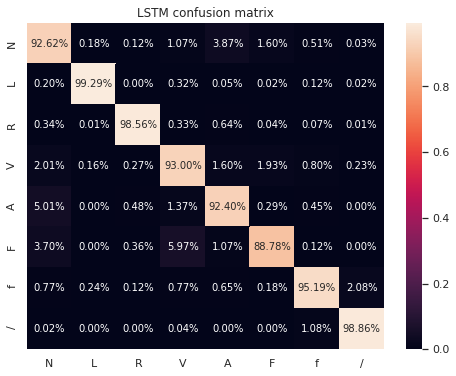

In [ ]:
# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=6, shuffle=True)

lstm_acc_list = []
lstm_pre_list = []
lstm_rec_list = []
lstm_f1_list = []
lstm_conf_list = []

# K-fold Cross Validation model evaluation
fold_no = 1

verbose, epoch, batch_size = 0, 5, 64
for train, test in kfold.split(inputs, targets):

  N = train[(targets[train])==1.0]
  L = train[(targets[train])==2.0]
  R = train[(targets[train])==3.0]
  V = train[(targets[train])==4.0]
  A = train[(targets[train])==5.0]
  F = train[(targets[train])==6.0]
  f = train[(targets[train])==7.0]
  I = train[(targets[train])==8.0]

  seed=42
  np.random.seed(seed)
  def downsample(arr, n, seed):
      downsampled = resample(arr,replace=False,n_samples=n, random_state=seed)
      return downsampled

  def upsample(arr, n, seed):
      upsampled = resample(arr,replace=True,n_samples=n,random_state=seed)
      return upsampled

  all_class = [N,L,R,V,A,F,f,I]
  abn_class = [L,R,V,A,F,f,I]

  mean_val = np.mean([len(i) for i in abn_class], dtype= int)
  train_sampled = []

  for i in all_class:
      if i.shape[0]> mean_val:
          i = downsample(i,mean_val,seed)
      elif i.shape[0]< mean_val:
          i = upsample(i, mean_val,seed)
      train_sampled.append(i)
      
  train_sampled = np.concatenate(train_sampled)
  np.random.shuffle(train_sampled)
  train1 = train_sampled

  targets1 = to_categorical(y)
  # Define the model architecture
  lstmmodel = Sequential()
  lstmmodel.add(LSTM(128, return_sequences=True, input_shape=(inputs[train1].shape[1],1)))
  lstmmodel.add(LSTM(9, return_sequences=True))
  lstmmodel.add(MaxPooling1D(pool_size=2))
  lstmmodel.add(Flatten())
  lstmmodel.add(Dense(512, activation=tf.nn.relu))    
  lstmmodel.add(Dense(128, activation=tf.nn.relu))    
  lstmmodel.add(Dense(32, activation=tf.nn.relu))
  lstmmodel.add(Dense(9, activation='softmax'))
  lstmmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

  print('Fold number: ', fold_no)

  # Fit data to model
  modelhistory= lstmmodel.fit(inputs[:,:,:,0][train1], targets1[train1], epochs=epoch, 
                             verbose=0, validation_split=0.2, 
                             batch_size = batch_size)
  
  y_pred_lstm = lstmmodel.predict(inputs[:,:,:,0][test], verbose=1)
  y_pred_lstm = np.argmax(y_pred_lstm,axis=1)
  lstm_actual = np.argmax(targets1[test],axis=1)

  lstm_acc_list.append(accuracy_score(lstm_actual, y_pred_lstm))
  lstm_pre_list.append(precision_score(lstm_actual, y_pred_lstm, average='macro'))
  lstm_rec_list.append(recall_score(lstm_actual, y_pred_lstm, average='macro'))
  lstm_f1_list.append(f1_score(lstm_actual, y_pred_lstm, average='macro'))
  lstm_cm = confusion_matrix(lstm_actual, y_pred_lstm)
  lstm_cm = lstm_cm.astype('float')/ lstm_cm.sum(axis=1)[:,np.newaxis]
  lstm_conf_list.append(lstm_cm)

  fold_no = fold_no + 1

perform_metrics('LSTM', lstm_acc_list, lstm_pre_list, lstm_rec_list, lstm_f1_list, lstm_conf_list)

In [ ]:
X = data[:,:-2]
y = data[:,-2]

inputs = X.reshape(X.shape + (1,1))
targets = (y)

print(inputs.shape)
print(targets.shape)

(151452, 220, 1, 1)
(151452,)


Fold number:  1
789/789 [==============================] - 2s 2ms/step
Fold number:  2
789/789 [==============================] - 1s 2ms/step
Fold number:  3
789/789 [==============================] - 1s 2ms/step
Fold number:  4
789/789 [==============================] - 2s 2ms/step
Fold number:  5
789/789 [==============================] - 1s 2ms/step
Fold number:  6
789/789 [==============================] - 1s 2ms/step
Classifier Name:  CNN
accuracy mean:  0.95  std:  0.01
precision:  0.796  std:  0.026
recall:  0.958  std:  0.005
f1score:  0.846  std:  0.023


('CNN', 0.95, 0.01, 0.796, 0.026, 0.958, 0.005, 0.846, 0.023)

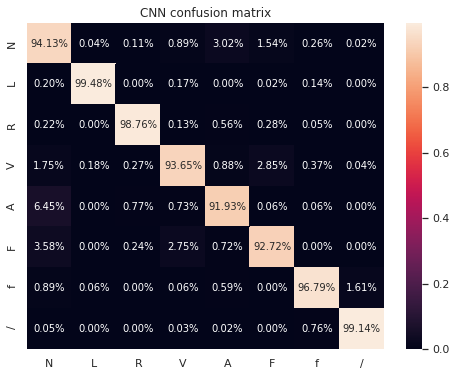

In [ ]:
# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=6, shuffle=True)

cnn_acc_list = []
cnn_pre_list = []
cnn_rec_list = []
cnn_f1_list = []
cnn_conf_list = []

# K-fold Cross Validation model evaluation
fold_no = 1

verbose, epoch, batch_size = 0, 5, 64
for train, test in kfold.split(inputs, targets):

  N = train[(targets[train])==1.0]
  L = train[(targets[train])==2.0]
  R = train[(targets[train])==3.0]
  V = train[(targets[train])==4.0]
  A = train[(targets[train])==5.0]
  F = train[(targets[train])==6.0]
  f = train[(targets[train])==7.0]
  I = train[(targets[train])==8.0]

  seed=42
  np.random.seed(seed)
  def downsample(arr, n, seed):
      downsampled = resample(arr,replace=False,n_samples=n, random_state=seed)
      return downsampled

  def upsample(arr, n, seed):
      upsampled = resample(arr,replace=True,n_samples=n,random_state=seed)
      return upsampled

  all_class = [N,L,R,V,A,F,f,I]
  abn_class = [L,R,V,A,F,f,I]

  mean_val = np.mean([len(i) for i in abn_class], dtype= int)
  train_sampled = []

  for i in all_class:
      if i.shape[0]> mean_val:
          i = downsample(i,mean_val,seed)
      elif i.shape[0]< mean_val:
          i = upsample(i, mean_val,seed)
      train_sampled.append(i)
      
  train_sampled = np.concatenate(train_sampled)
  np.random.shuffle(train_sampled)
  train1 = train_sampled

  targets1 = to_categorical(y)
  # Define the model architecture
  cnnmodel = Sequential()
  cnnmodel.add(Conv1D(filters=128, kernel_size=16,padding='same', activation='relu',input_shape=(inputs[train1].shape[1],1)))
  cnnmodel.add(BatchNormalization())
  cnnmodel.add(Conv1D(filters=32, kernel_size=16,padding='same', activation='relu'))
  cnnmodel.add(BatchNormalization())
  cnnmodel.add(Conv1D(filters=9, kernel_size=16,padding='same', activation='relu'))
  cnnmodel.add(MaxPooling1D(pool_size=2,padding='same'))
  cnnmodel.add(Flatten())
  cnnmodel.add(Dense(512, activation='relu'))
  cnnmodel.add(Dense(128, activation='relu'))
  cnnmodel.add(Dense(32, activation='relu'))
  cnnmodel.add(Dense(9, activation='softmax'))
  cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

  print('Fold number: ', fold_no)

  # Fit data to model
  modelhistory= cnnmodel.fit(inputs[:,:,:,0][train1], targets1[train1], epochs=epoch, 
                             verbose=verbose, validation_split=0.2, 
                             batch_size = batch_size)
  
  y_pred_cnn = cnnmodel.predict(inputs[:,:,:,0][test], verbose=1)
  y_pred_cnn = np.argmax(y_pred_cnn,axis=1)
  cnn_actual = np.argmax(targets1[test],axis=1)

  cnn_acc_list.append(accuracy_score(cnn_actual, y_pred_cnn))
  cnn_pre_list.append(precision_score(cnn_actual, y_pred_cnn, average='macro'))
  cnn_rec_list.append(recall_score(cnn_actual, y_pred_cnn, average='macro'))
  cnn_f1_list.append(f1_score(cnn_actual, y_pred_cnn, average='macro'))
  cnn_cm = confusion_matrix(cnn_actual, y_pred_cnn)
  cnn_cm = cnn_cm.astype('float')/ cnn_cm.sum(axis=1)[:,np.newaxis]
  cnn_conf_list.append(cnn_cm)

  fold_no = fold_no + 1

perform_metrics('CNN', cnn_acc_list, cnn_pre_list, cnn_rec_list, cnn_f1_list, cnn_conf_list)

Classifier Name:  LSTM
accuracy mean:  0.937  std:  0.006
precision:  0.766  std:  0.023
recall:  0.948  std:  0.007
f1score:  0.821  std:  0.016
Classifier Name:  CNN
accuracy mean:  0.95  std:  0.01
precision:  0.796  std:  0.026
recall:  0.958  std:  0.005
f1score:  0.846  std:  0.023


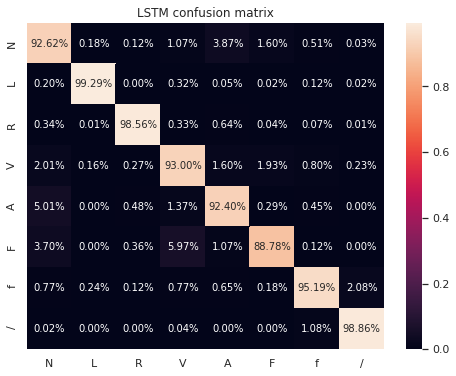

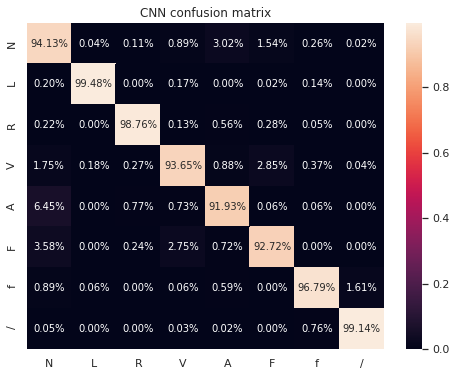

In [ ]:
LSTM_results = perform_metrics('LSTM', lstm_acc_list, lstm_pre_list, lstm_rec_list, lstm_f1_list, lstm_conf_list)
CNN_results = perform_metrics('CNN', cnn_acc_list, cnn_pre_list, cnn_rec_list, cnn_f1_list, cnn_conf_list)

In [ ]:
keras_results = pd.DataFrame(data = (LSTM_results, CNN_results))

In [ ]:
print(keras_results)
keras_results.to_csv('keras_cv_results.csv', encoding='utf-8', index=False)

      0      1      2      3      4      5      6      7      8
0  LSTM  0.937  0.006  0.766  0.023  0.948  0.007  0.821  0.016
1   CNN  0.950  0.010  0.796  0.026  0.958  0.005  0.846  0.023


In [ ]:
LSTM_acc = pd.DataFrame(lstm_acc_list)
LSTM_acc.to_csv('LSTM_acc.csv', encoding='utf-8', index=False)

LSTM_pre = pd.DataFrame(lstm_pre_list)
LSTM_pre.to_csv('LSTM_pre.csv', encoding='utf-8', index=False)

LSTM_rec = pd.DataFrame(lstm_rec_list)
LSTM_rec.to_csv('LSTM_rec.csv', encoding='utf-8', index=False)

LSTM_f1s = pd.DataFrame(lstm_f1_list)
LSTM_f1s.to_csv('LSTM_f1s.csv', encoding='utf-8', index=False)

In [ ]:
CNN_acc = pd.DataFrame(cnn_acc_list)
CNN_acc.to_csv('CNN_acc.csv', encoding='utf-8', index=False)

CNN_pre = pd.DataFrame(cnn_pre_list)
CNN_pre.to_csv('CNN_pre.csv', encoding='utf-8', index=False)

CNN_rec = pd.DataFrame(cnn_rec_list)
CNN_rec.to_csv('CNN_rec.csv', encoding='utf-8', index=False)

CNN_f1s = pd.DataFrame(cnn_f1_list)
CNN_f1s.to_csv('CNN_f1s.csv', encoding='utf-8', index=False)